## Table of Contents

- [1. Data Extraction & Preprocessing](#1)
- [2. Exploratory Data Analysis](#2)
- [3. Evaluation Procedure](#3)
    - [3.1 Normalization](#3_1)
    - [3.2 Data Splitting](#3_2)
- [4. Model Training](#4)
    - [4.1 Model 0 - Constant ](#4_1)
    - [4.2 Model 1 - NLTK, TF-IDF and LR](#4_2)
    - [4.3 Model 2 - spaCy, TF-IDF and LR](#4_3)
    - [4.4 Model 3 - spaCy, TF-IDF and LGBMClassifier](#4_4)
    - [4.5 Model 4 - BERT](#4_5)
- [5. Sample Reviews](#5)
    - [4.1 Model 1 - NLTK, TF-IDF and LR](#5_1)
    - [4.2 Model 2 - spaCy, TF-IDF and LR](#5_2)
    - [4.3 Model 3 - spaCy, TF-IDF and LGBMClassifier](#5_3)
    - [4.4 Model 4 - BERT](#5_4)
- [Conclusion](#end)

### 1. Data Extraction & Preprocessing <a class="anchor" id="1"></a>

In [1]:
import math
import re
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from lightgbm import LGBMClassifier

import spacy
import torch
import transformers

from tqdm.auto import tqdm
from IPython.display import display

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

In [4]:
try:
    df_reviews = pd.read_csv('../datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
    display(df_reviews.sample(4))
except:
    print("data not found")

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
11067,tt0080661,movie,Dressed to Kill,Dressed to Kill,1980,\N,104,0,"Mystery,Thriller",7.1,33521,"i just finished watching Dressed to Kill,which...",10,pos,1,train,6847
30798,tt0019379,movie,Show People,Show People,1928,\N,83,0,"Comedy,Romance",7.6,3439,"1928 is in many ways a ""lost year"" in motion p...",9,pos,1,train,189
25645,tt0422909,movie,Panaghóy sa subâ: The Call of the River,Panaghóy sa subâ: The Call of the River,2004,\N,120,0,"Drama,Romance,War",7.1,58,I was excited to hear that Cesar Montano had d...,4,neg,0,train,3206
3632,tt0034486,movie,Baby Face Morgan,Baby Face Morgan,1942,\N,63,0,"Comedy,Crime,Romance",5.2,190,"If you want to make a movie like this, have th...",4,neg,0,train,4878


We will check for nulls or duplicates:

In [5]:
display(df_reviews.isna().sum())

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [6]:
df_reviews[df_reviews['average_rating'].isnull() | df_reviews['votes'].isnull()]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


There are few enough nulls that they can simply be dropped.

In [7]:
df_no_na = df_reviews[
    (df_reviews["average_rating"].notna()) & 
    (df_reviews["votes"].notna())
]
drops_null = df_reviews.shape[0] - df_no_na.shape[0]
print("{} rows with nulls were dropped".format(drops_null))

2 rows with nulls were dropped


In [8]:
df_no_dupe = df_no_na.drop_duplicates(inplace=False)
df_no_dupe = df_no_dupe.reset_index(drop=True) 
drops_dupe = df_no_na.shape[0] - df_no_dupe.shape[0]
print("There were {} duplicates".format(drops_dupe))
df_reviews = df_no_dupe
del df_no_na
del df_no_dupe

There were 0 duplicates


### 2. Exploratory Data Analysis <a class="anchor" id="2"></a>

Let's check the number of movies and reviews over years.

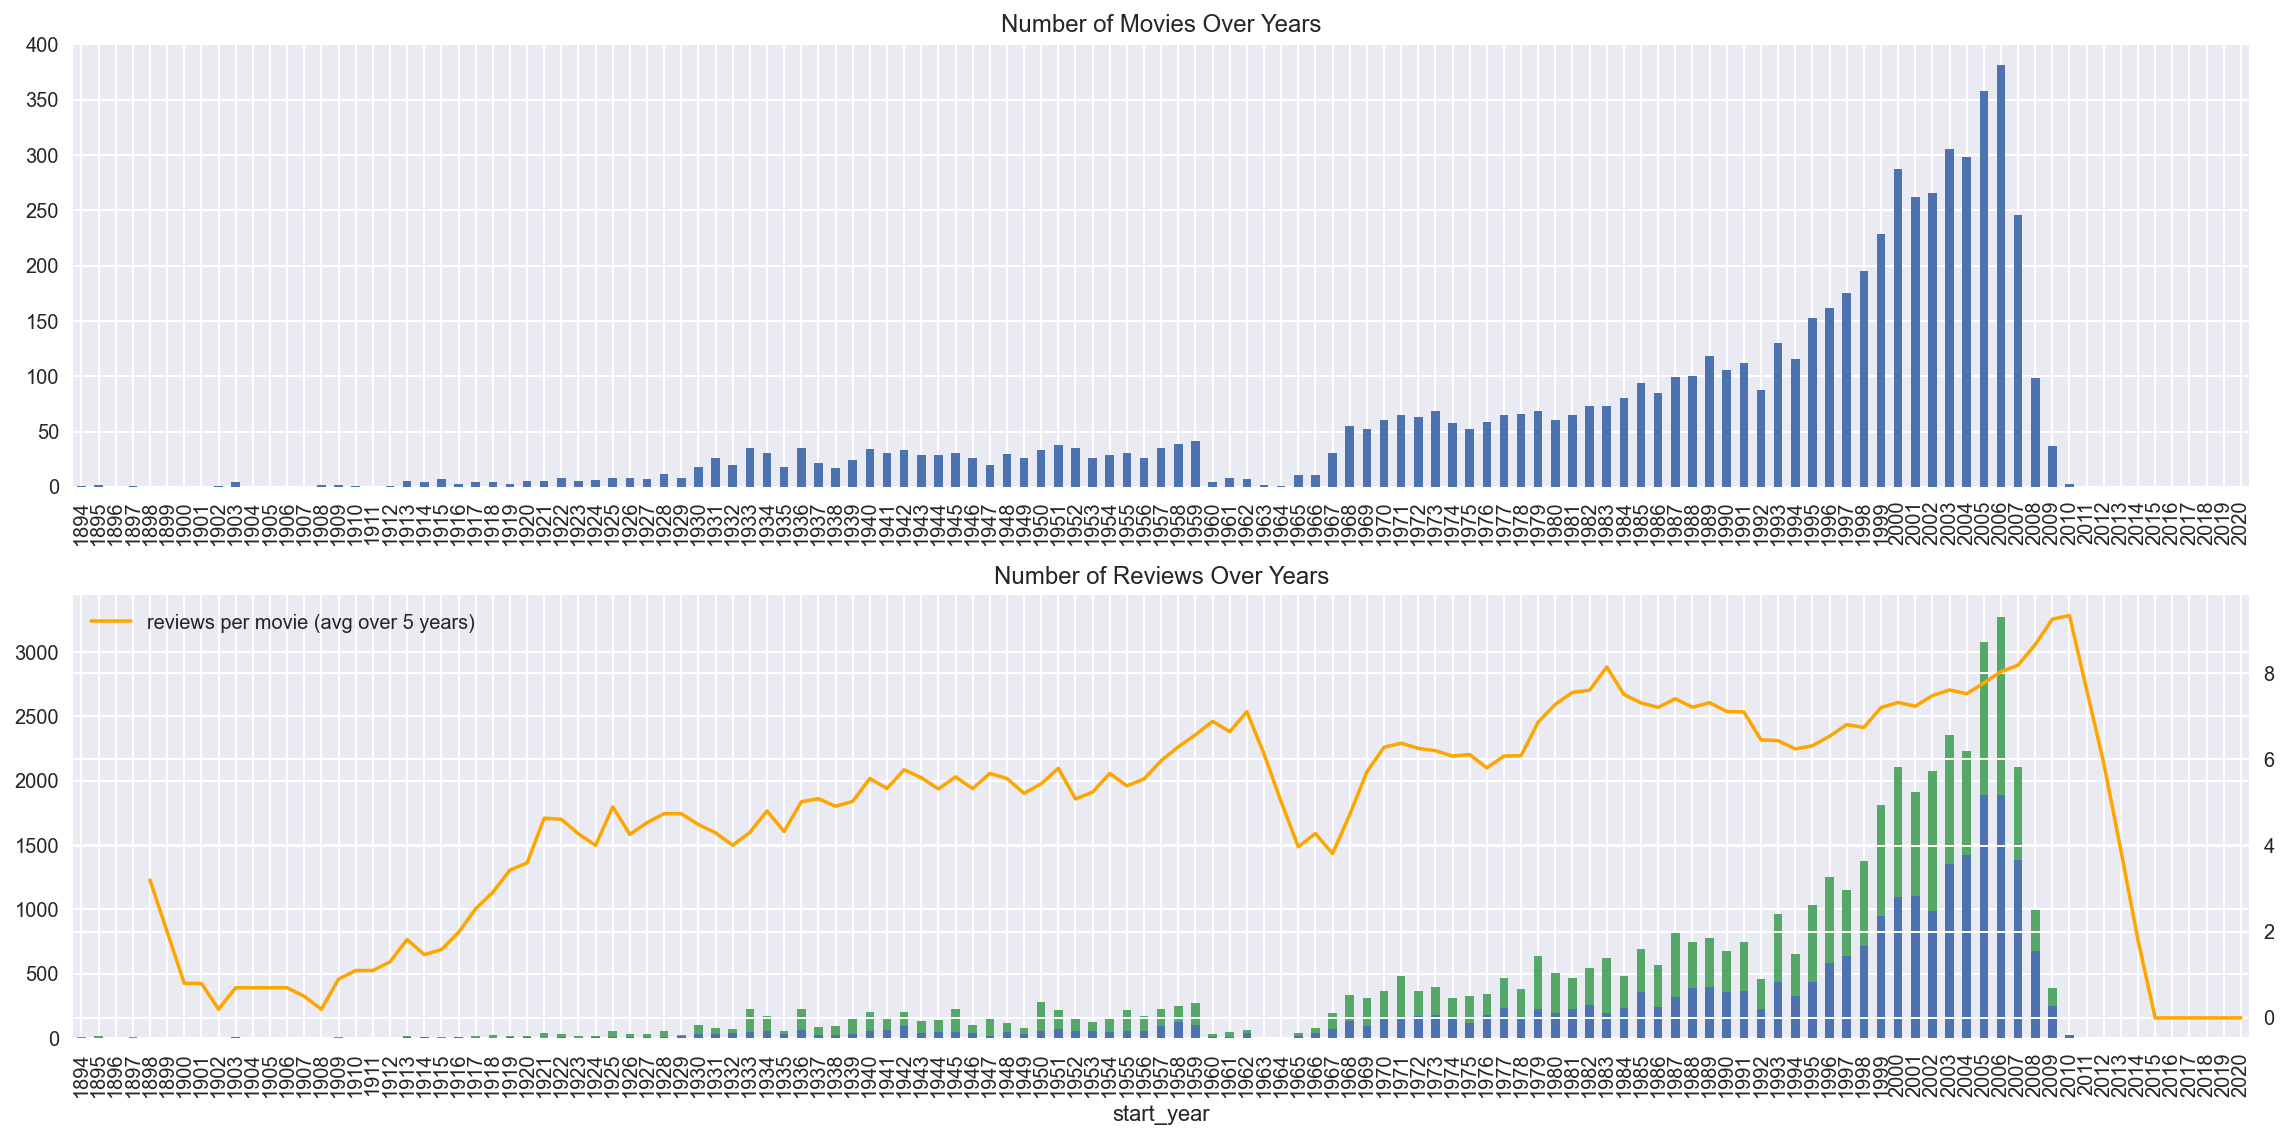

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

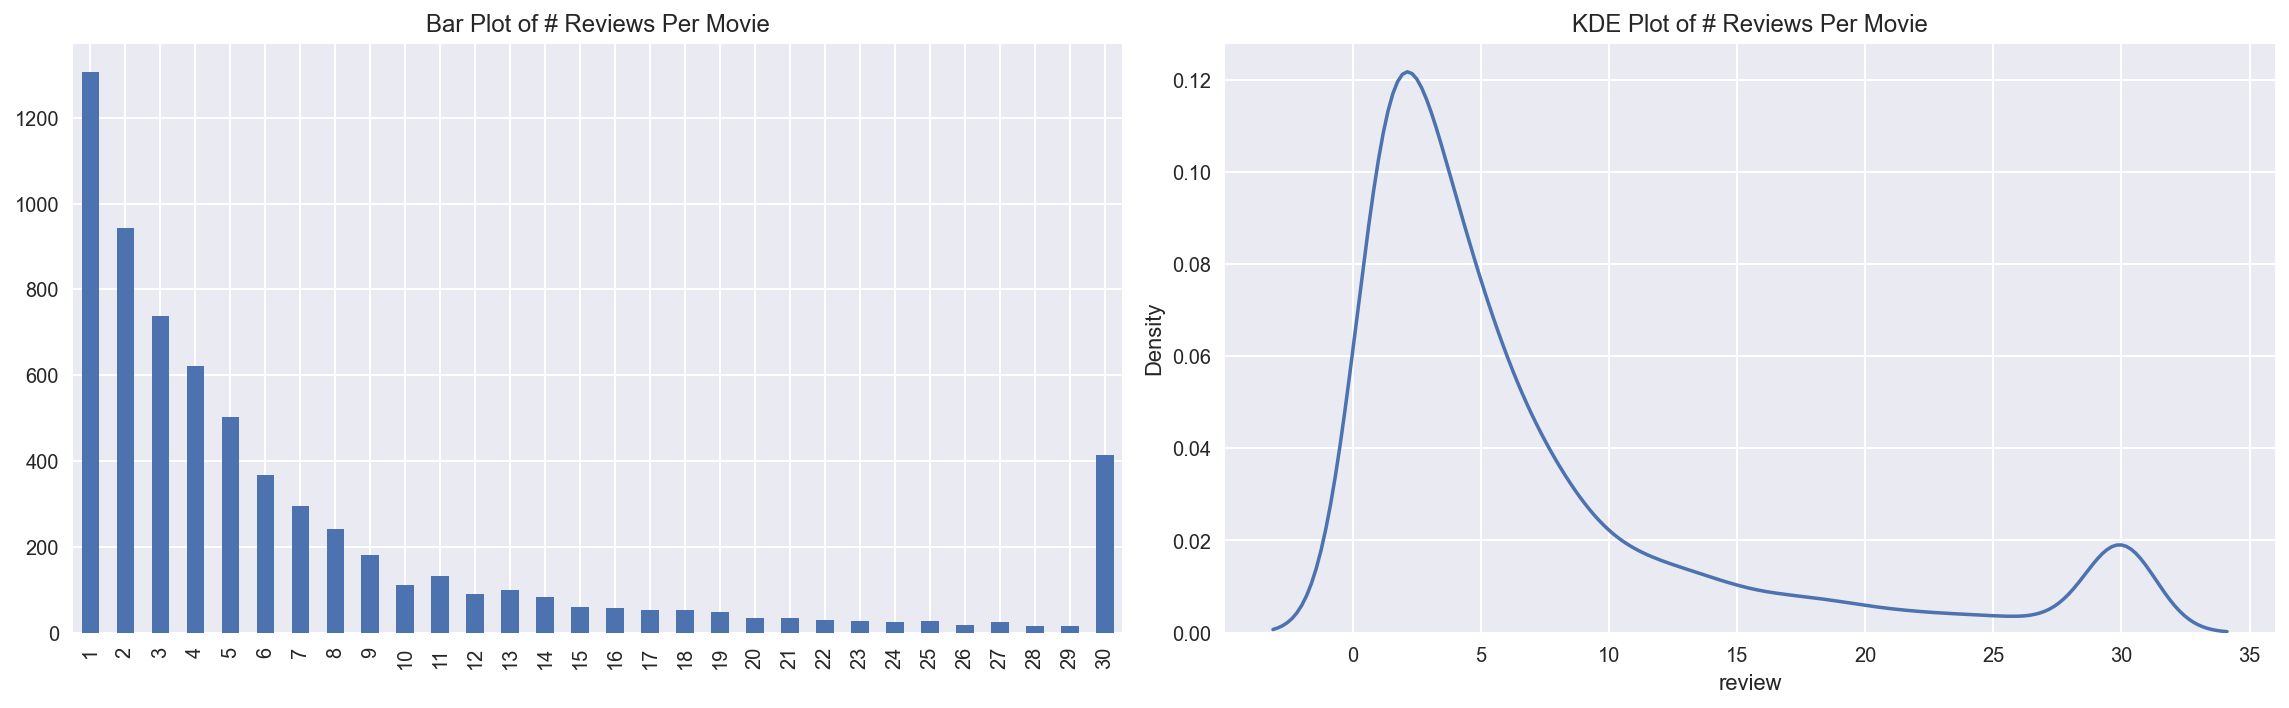

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of # Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of # Reviews Per Movie')

fig.tight_layout()

We can see an outlier group of some movies that received a large number of reviews. This group won't have an effect on models because the positivity of a review isn't necessarily dependent on the number of reviews.

In [11]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

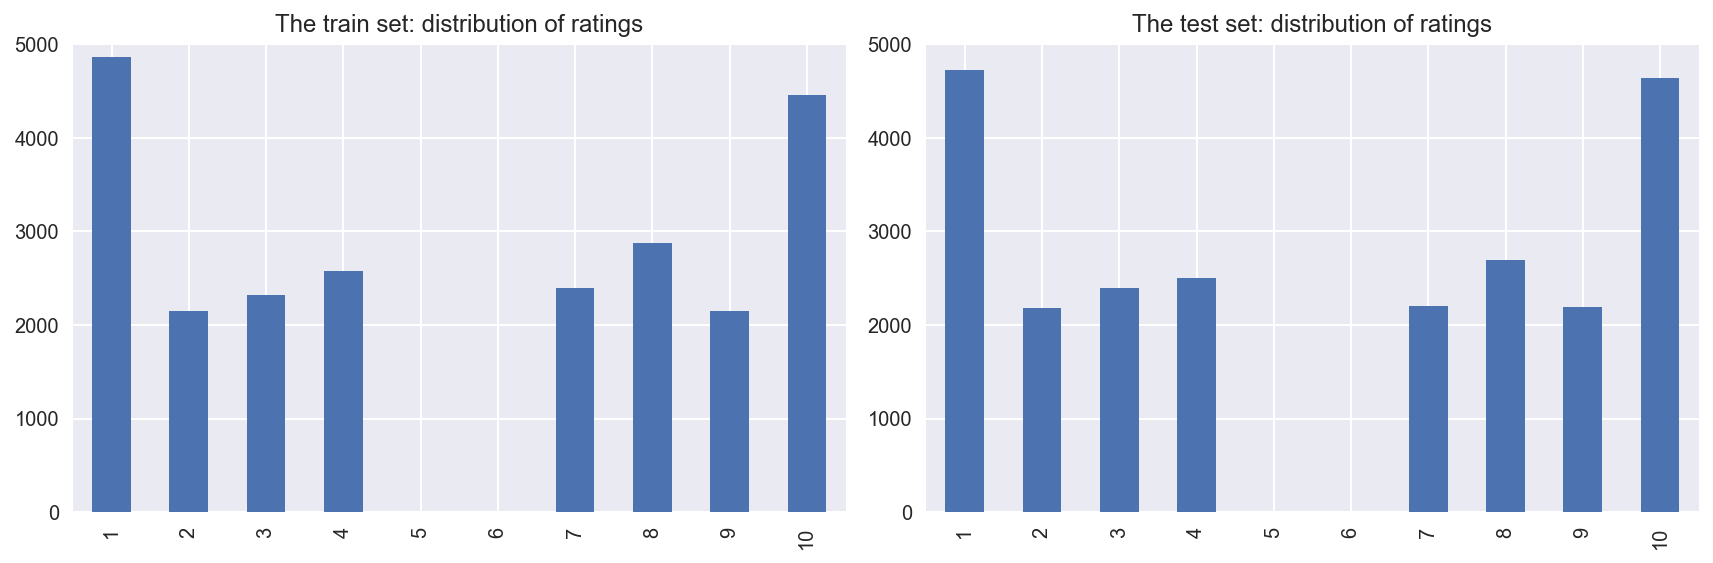

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

The training set and test set have very similar distribution of ratings.

Distribution of negative and positive reviews over the years for two parts of the dataset:

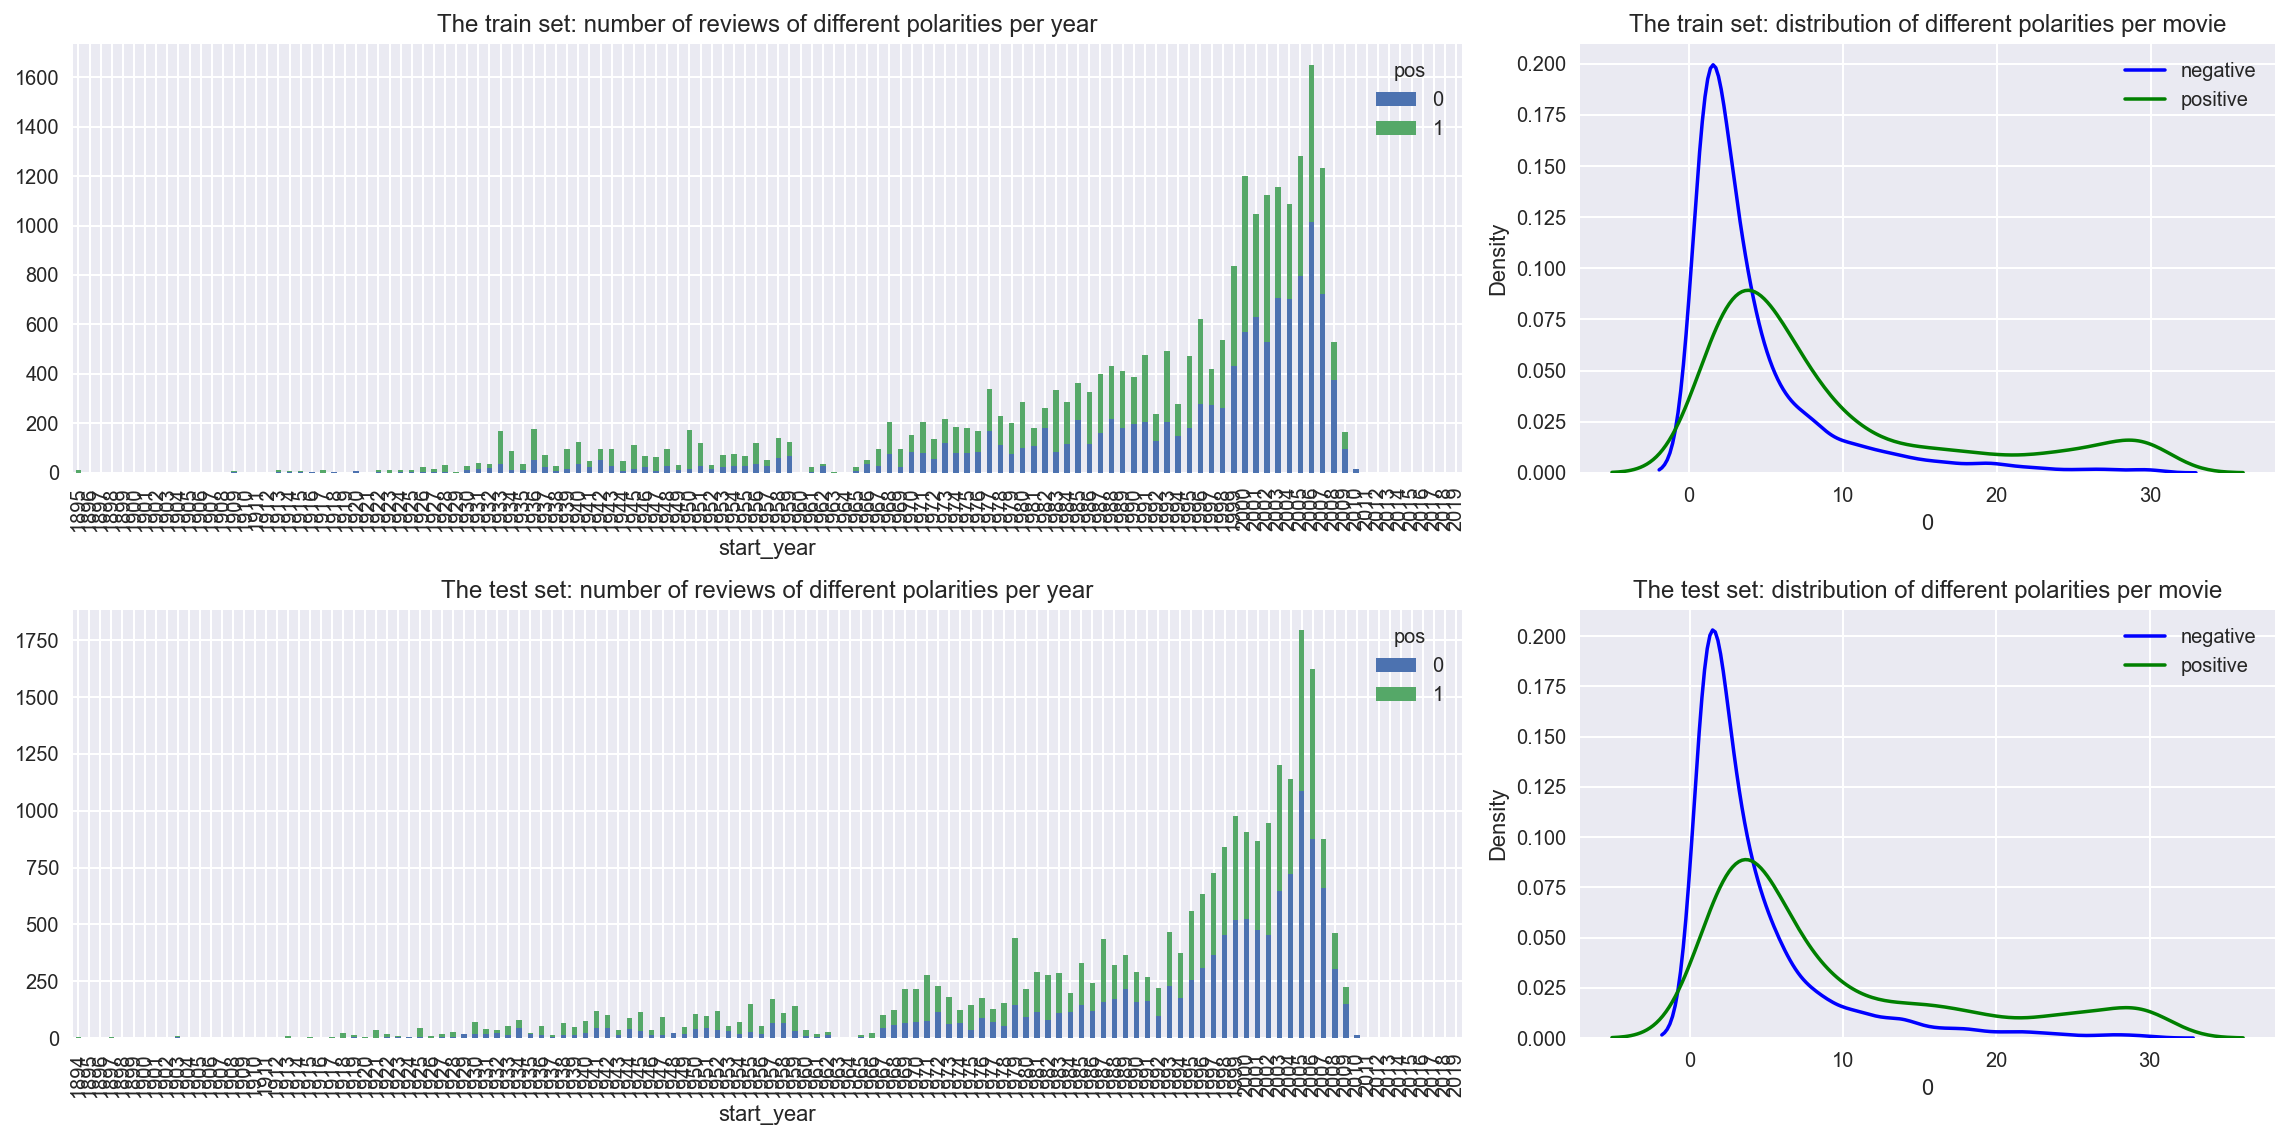

In [13]:
warnings.filterwarnings("ignore")

fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

The training and test sets also have similar distribution of number and polarity of reviews by year and by movie.

### 3. Evaluation Procedure <a class="anchor" id="3"></a>

Composing an evaluation routine which can be used for all models.

In [14]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    display(df_eval_stats)
    
    return

#### 3.1 Normalization <a class="anchor" id="3_1"></a>

We assume all models below accept texts in lowercase and without any digits, punctuations marks etc.

In [15]:
def normalize_review(review):
    #remove non-standard characters
    review = re.sub(r"[^A-Za-z]", " ", review)
    
    #remove extra whitespace
    review = re.sub(r" +", " ", review)
    return review.lower()

df_reviews['review_norm'] = df_reviews['review'].apply(normalize_review)
df_reviews[['review','review_norm']].sample(4)

,review,review_norm
37476,I won't repeat all that has been said already ...,i won t repeat all that has been said already ...
29001,"Though this movie is cheesiness at its best, i...",though this movie is cheesiness at its best it...
34106,"A romp across a disbelieving outback, this out...",a romp across a disbelieving outback this outr...
29712,Jerk hazer Mike(David Zelina playing this coll...,jerk hazer mike david zelina playing this coll...


#### 3.2 Data Splitting <a class="anchor" id="3_2"></a>

The whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [16]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_features = df_reviews_train['review_norm']
train_target = df_reviews_train['pos']
test_features = df_reviews_test['review_norm']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


### 4. Model Training <a class="anchor" id="4"></a>

### 4.1 Model 0 - Constant <a class="anchor" id="4_1"></a>

,train,test
Accuracy,0.5,0.5
F1,0.0,0.0
APS,0.5,0.5
ROC AUC,0.5,0.5


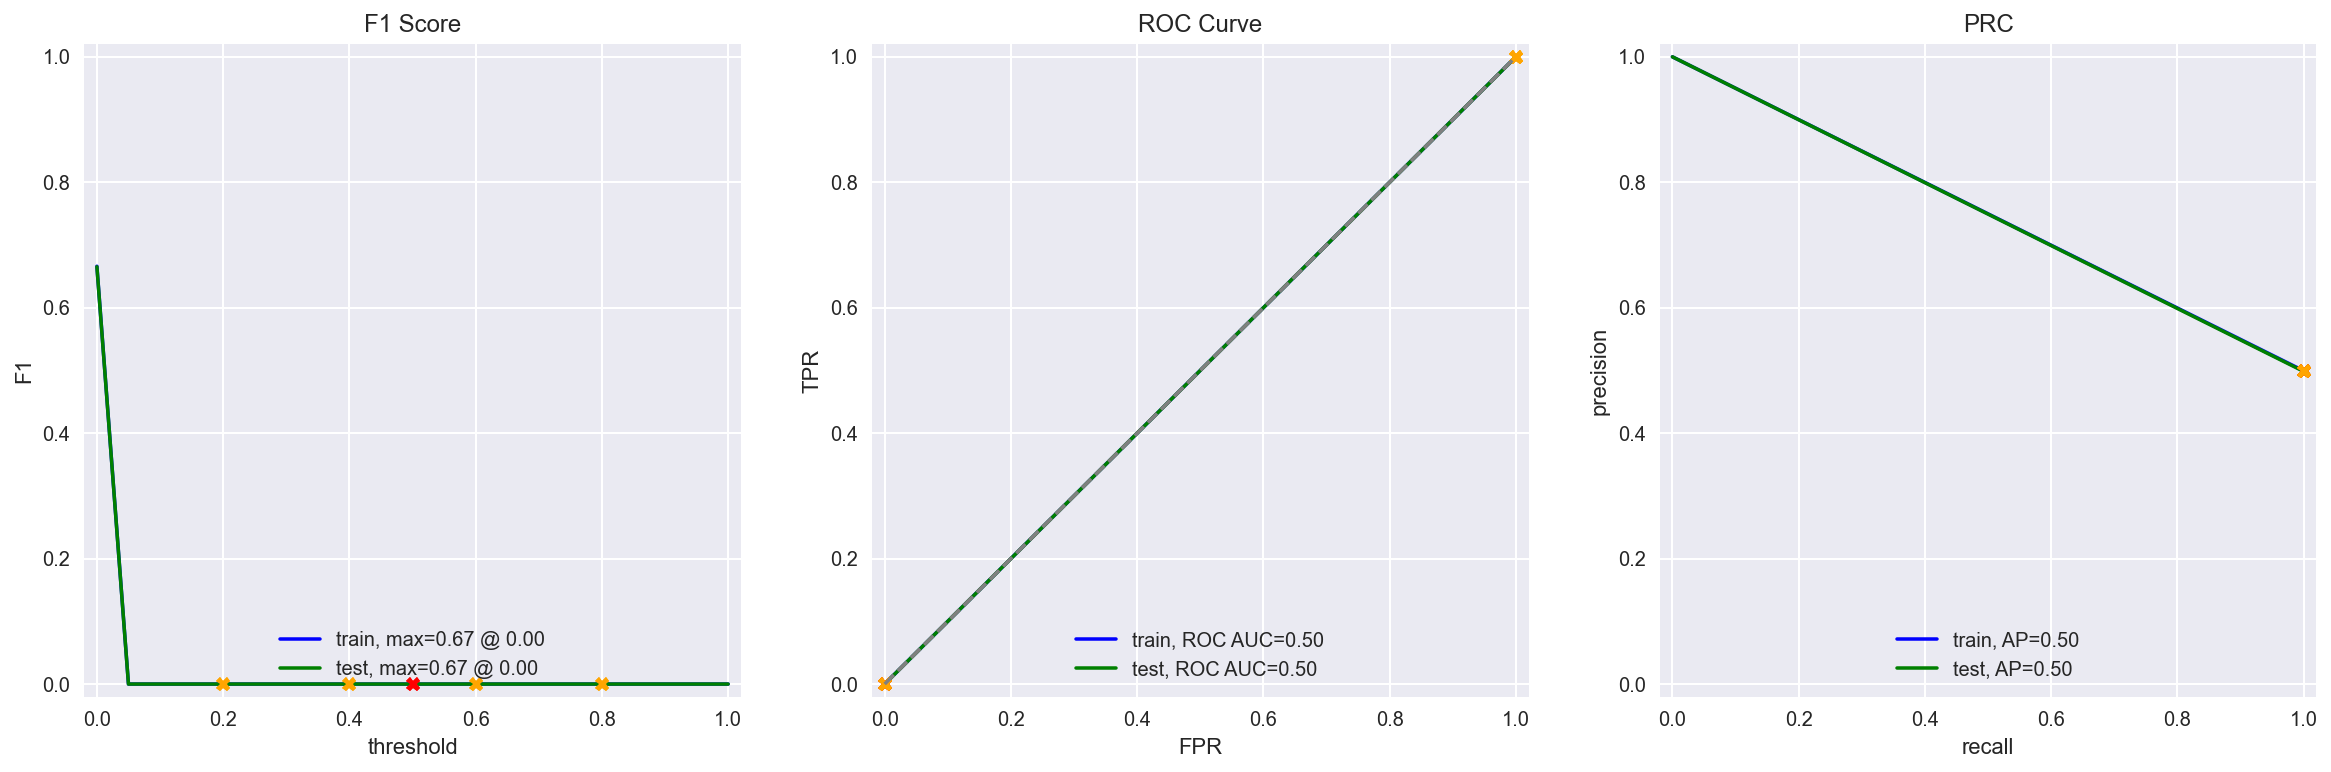

In [17]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train_features, train_target)

evaluate_model(dummy_clf, train_features, train_target, test_features, test_target)

There is virtually no accuracy with the dummy model.

#### 4.2 Model 1 - NLTK, TF-IDF and LR <a class="anchor" id="4_2"></a>

,train,test
Accuracy,0.94,0.88
F1,0.94,0.88
APS,0.98,0.95
ROC AUC,0.98,0.95


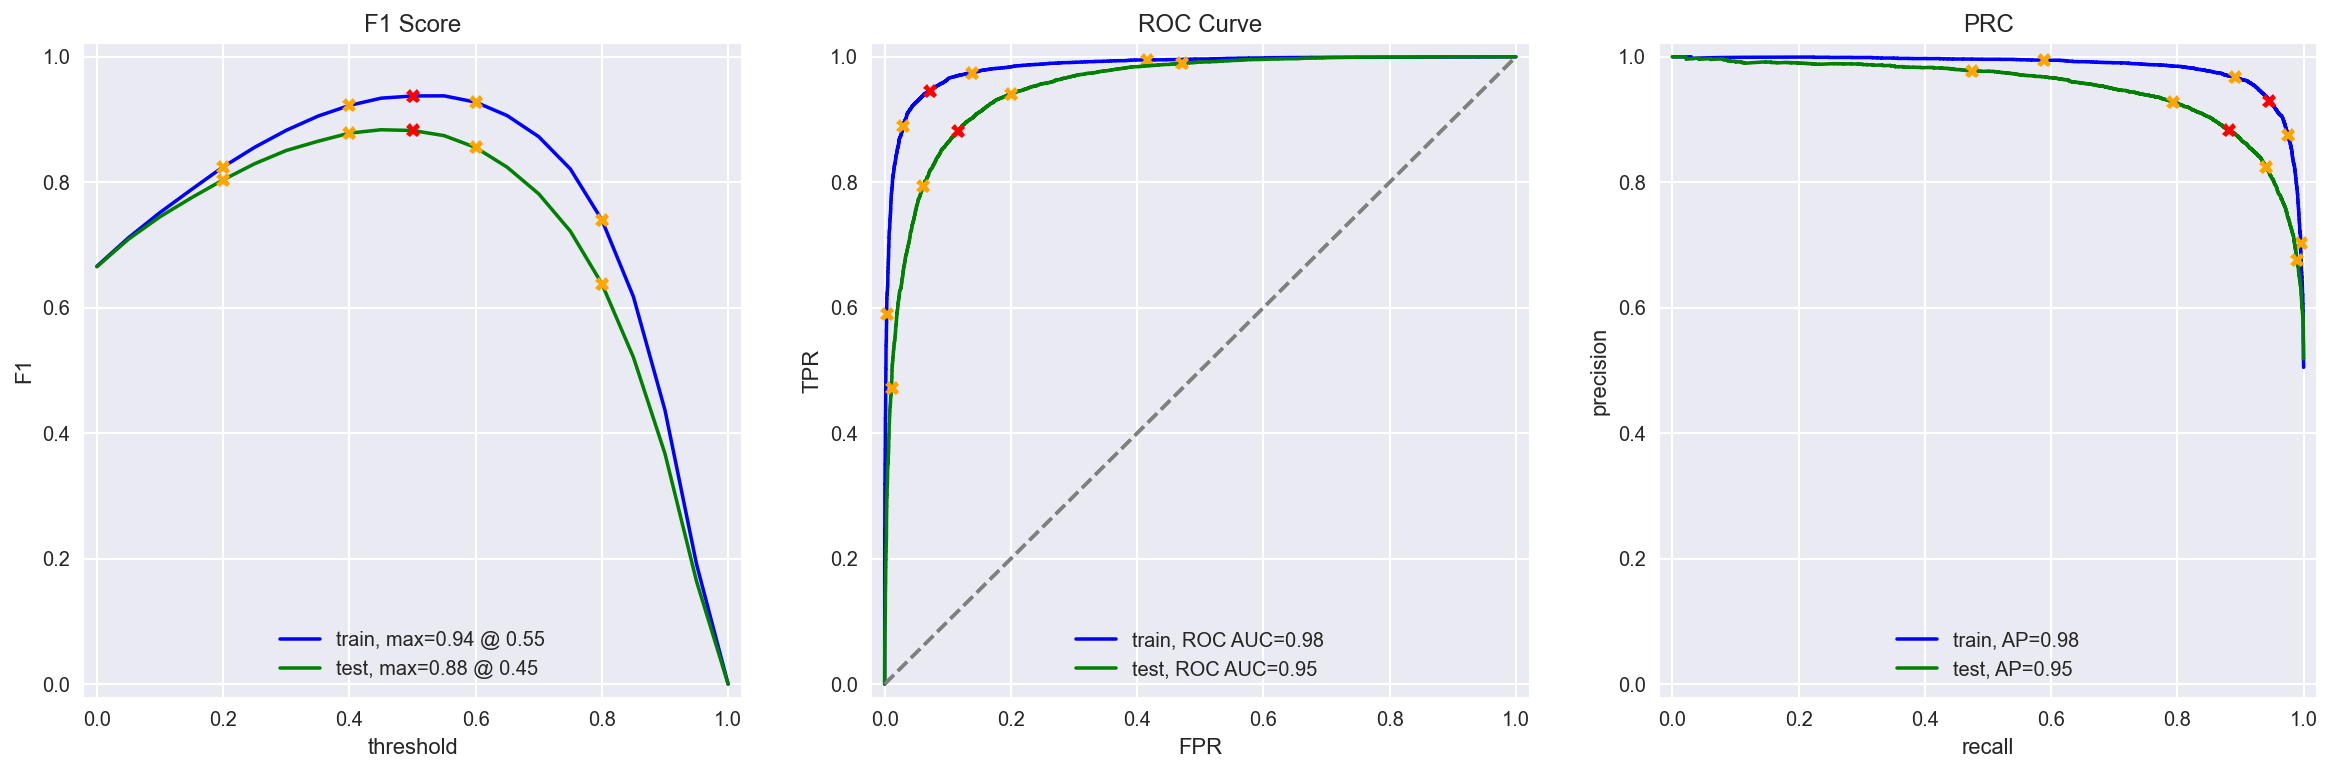

In [18]:
stop_words = set(stopwords.words('english'))

vect = TfidfVectorizer(stop_words=stop_words)
vect.fit(train_features)
train_features_1 = vect.transform(train_features)
test_features_1 = vect.transform(test_features)

model_1 = LogisticRegression()
model_1.fit(train_features_1,train_target)

evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

Model 1 has achieved a good level of accuracy according to our threshold of 85%.

### 4.3 Model 2 - spaCy, TF-IDF and LR <a class="anchor" id="4_3"></a>

In [19]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [20]:
def lemmatization(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [21]:
# lemmatization process takes a while
train_processed = train_features.progress_apply(lemmatization)

  0%|          | 0/23796 [00:00<?, ?it/s]

In [22]:
test_processed = test_features.progress_apply(lemmatization)

  0%|          | 0/23533 [00:00<?, ?it/s]

In [23]:
tfidf_vectorizer_2 = TfidfVectorizer(stop_words=stop_words).fit(train_processed)
train_features_2 = tfidf_vectorizer_2.transform(train_processed)
test_features_2 = tfidf_vectorizer_2.transform(test_processed)

,train,test
Accuracy,0.93,0.88
F1,0.93,0.88
APS,0.98,0.95
ROC AUC,0.98,0.95


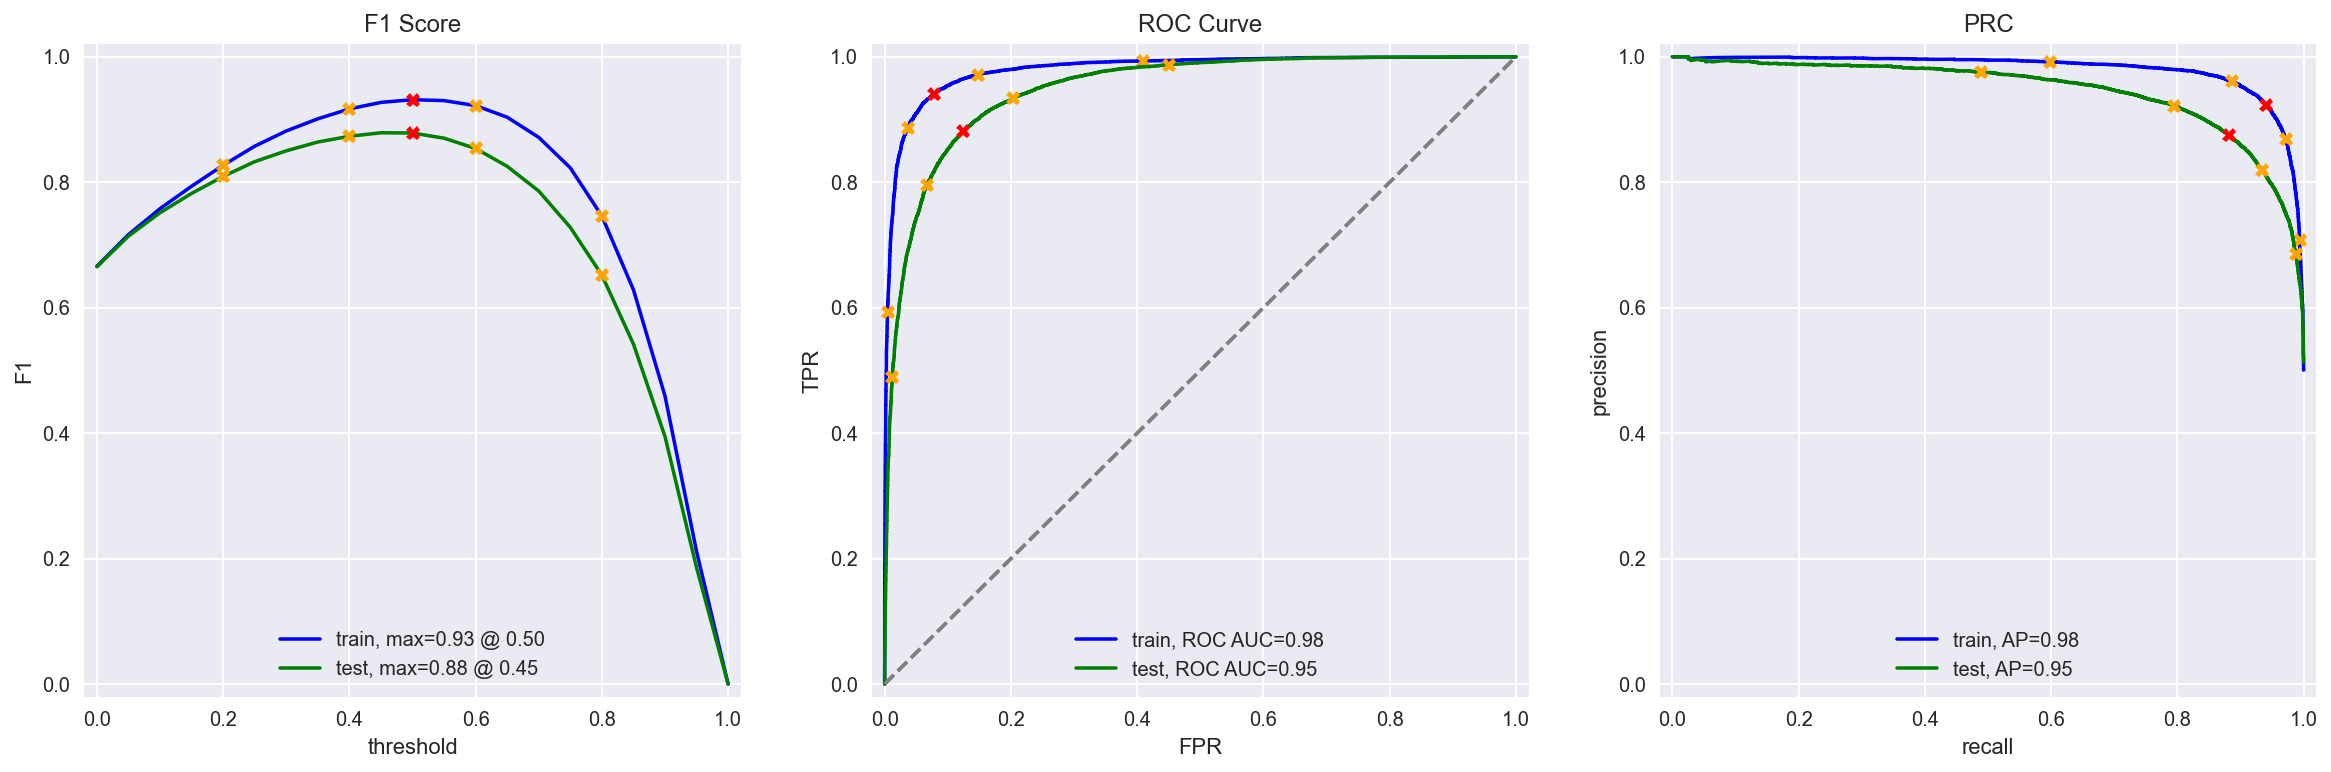

In [24]:
model_2 = LogisticRegression()
model_2.fit(train_features_2,train_target)

evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

Model 2 performed accurately similar to model 1 but needs far more time to lemmatize text features.

### 4.4 Model 3 - spaCy, TF-IDF and LGBMClassifier <a class="anchor" id="4_4"></a>

In [39]:
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stop_words).fit(train_processed)
train_features_3 = tfidf_vectorizer_3.transform(train_processed)
test_features_3 = tfidf_vectorizer_3.transform(test_processed)

,train,test
Accuracy,0.91,0.86
F1,0.91,0.86
APS,0.97,0.93
ROC AUC,0.97,0.94


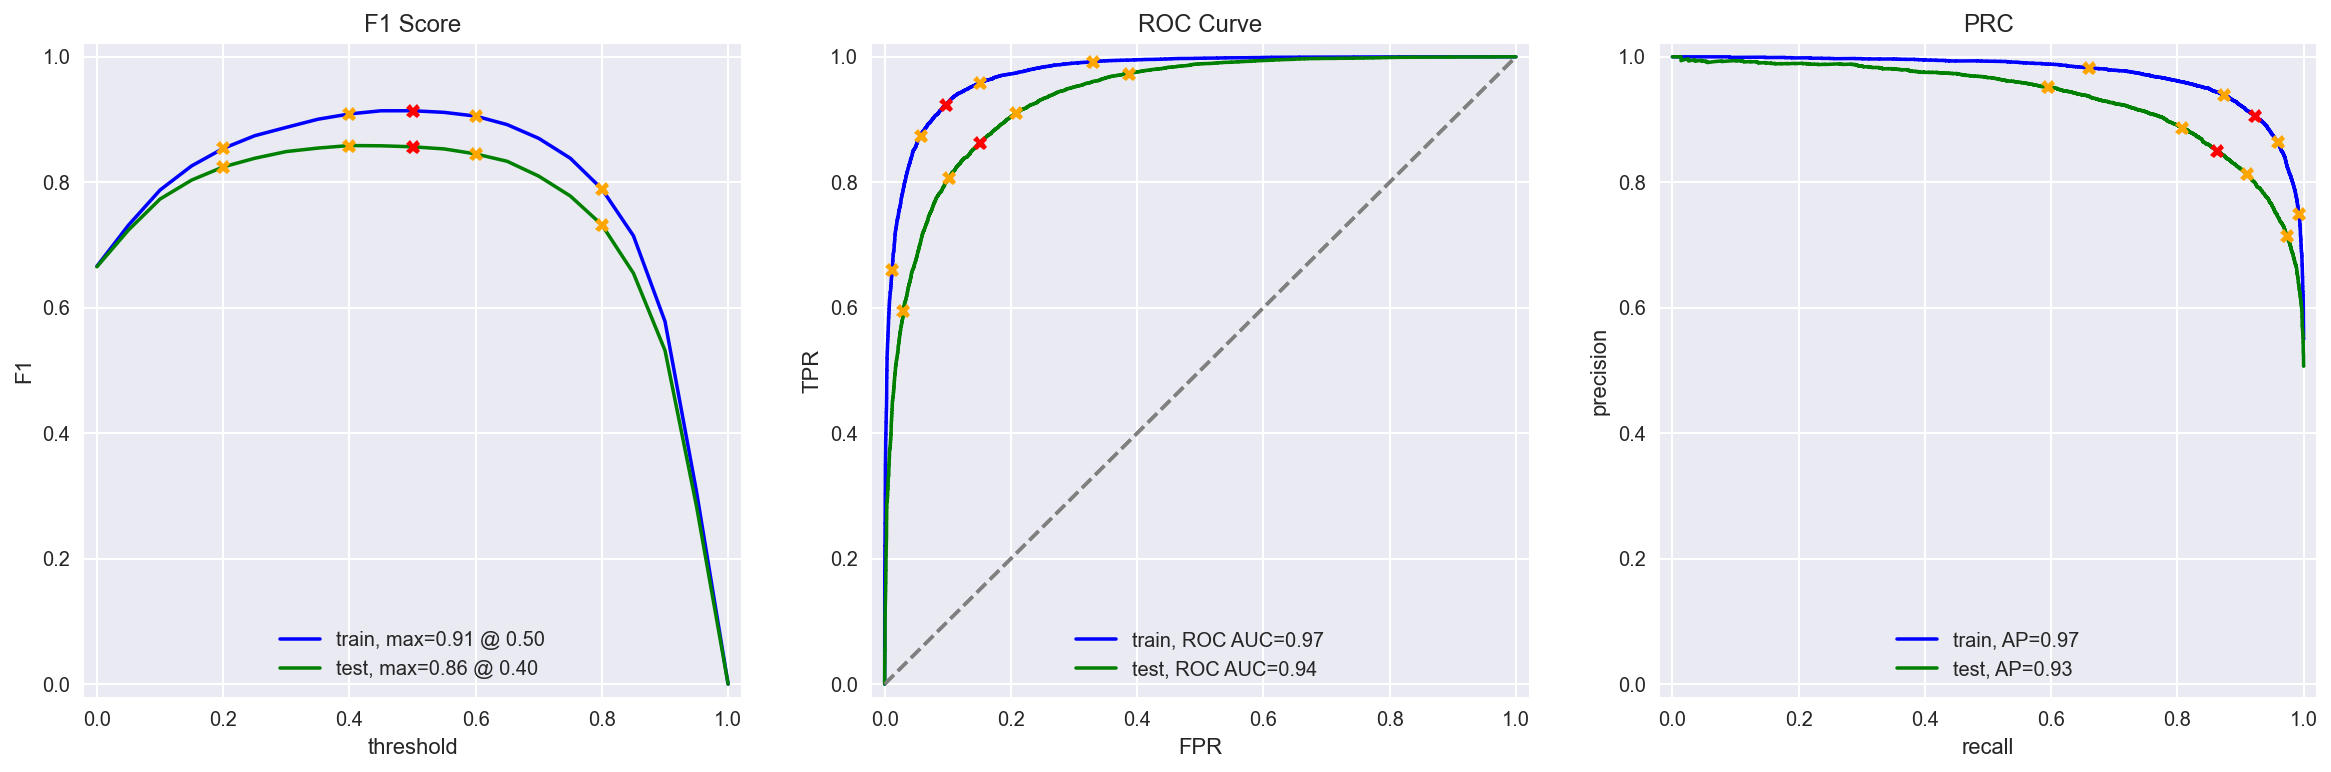

In [40]:
model_3 = LGBMClassifier()
model_3.fit(train_features_3,train_target)

evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

The LightGBM model with spaCy and TF-IDF is only slightly less accurate than the previous models using a linear regression. Regression is more appropriate than classification in this task because positivity is not an entirely binary concept. Also, hypertuning parameters for this model could yield better accuracy but will take too much time due to CPU limitations.

###  4.5 Model 4 - BERT <a class="anchor" id="4_5"></a>

In [26]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
def BERT_text_to_embeddings(texts, max_sample_size=200,max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    for input_text in tqdm(texts[:max_sample_size], disable=disable_progress_bar):
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)

    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [28]:
# limiting sample size because of cpu limitations
MAX_SAMPLE_SIZE = 2000

train_features_4 = BERT_text_to_embeddings(train_features,max_sample_size=MAX_SAMPLE_SIZE)

  0%|          | 0/2000 [00:00<?, ?it/s]

Using the cpu device.


  0%|          | 0/20 [00:00<?, ?it/s]

In [29]:
test_features_4 = BERT_text_to_embeddings(test_features,max_sample_size=MAX_SAMPLE_SIZE)

  0%|          | 0/2000 [00:00<?, ?it/s]

Using the cpu device.


  0%|          | 0/20 [00:00<?, ?it/s]

In [30]:
# save embeddings
np.savez_compressed('features_4.npz', train_features_4=train_features_4, test_features_4=test_features_4)

# load embeddings
#with np.load('features_4.npz') as data:
#    train_features_4 = data['train_features_4']
#    test_features_4 = data['test_features_4']

In [31]:
print(train_features.shape)
print(train_features_4.shape)
print(train_target.shape)

print(test_features.shape)
print(test_features_4.shape)
print(test_target.shape)

(23796,)
(2000, 768)
(23796,)
(23533,)
(2000, 768)
(23533,)


In [32]:
model_4 = LogisticRegression()
model_4.fit(train_features_4,train_target[:train_features_4.shape[0]])

LogisticRegression()

,train,test
Accuracy,0.96,0.82
F1,0.96,0.81
APS,0.99,0.91
ROC AUC,0.99,0.91


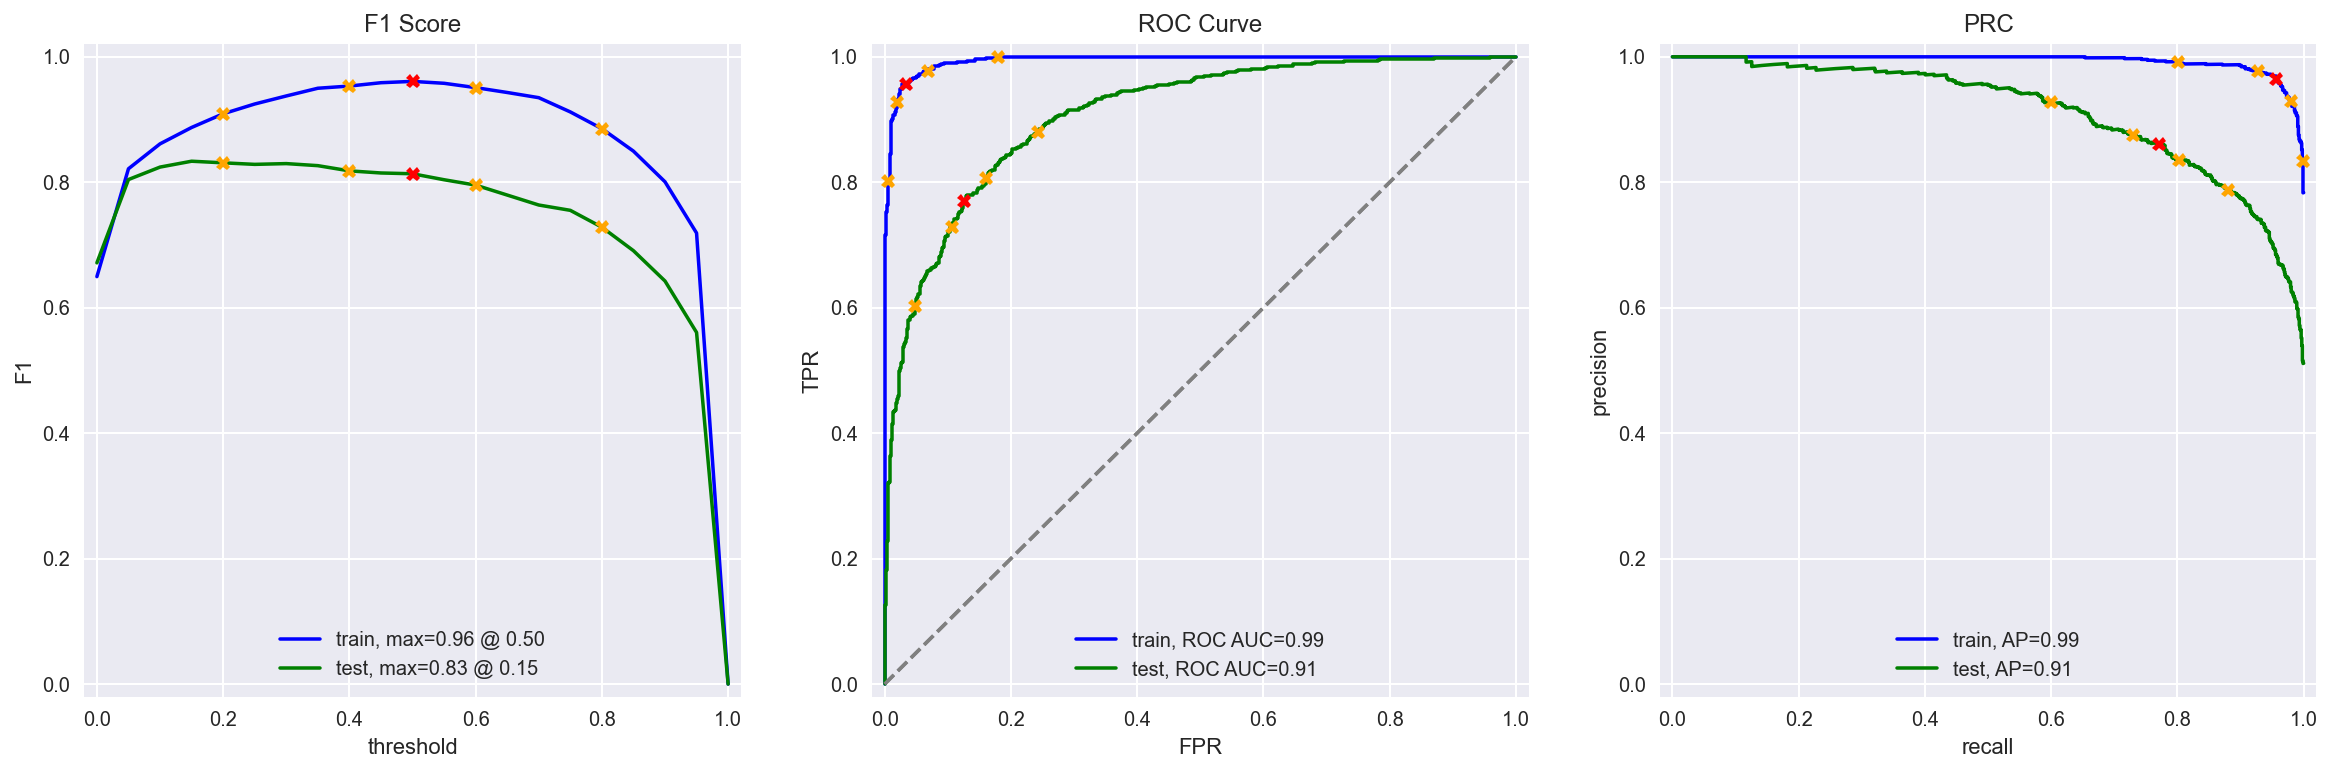

In [33]:
evaluate_model(
    model_4, 
    train_features_4, 
    train_target[:(train_features_4.shape[0])], 
    test_features_4, 
    test_target[:(test_features_4.shape[0])]
)

Model 4 performed well on the training data but was innacurate on the test data because it is overfitted on a smaller sample size due to CPU limitations. It also took the longest time.

### 5. Example Reviews <a class="anchor" id="5"></a>

In [34]:
# creating highly positive, neutral, and highly negative example review to test
my_reviews = pd.DataFrame([
    'This is my favorite kind of movie. I loved every second of it. Pure joy.',
    'I though it was ok.',
    'Words cannot express how severely I dislike this soulless garbage.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(normalize_review)
my_reviews

,review,review_norm
0,This is my favorite kind of movie. I loved eve...,this is my favorite kind of movie i loved ever...
1,I though it was ok.,i though it was ok
2,Words cannot express how severely I dislike th...,words cannot express how severely i dislike th...


#### 5.1 Model 1 - NLTK, TF-IDF and LR <a class="anchor" id="5_1"></a>

In [35]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(TfidfVectorizer(stop_words=stop_words).fit(train_features).transform(texts))[:, 1]

review_predictions = pd.DataFrame(columns=['pos_pred','review'])

for i, review in enumerate(texts.str.slice(0, 100)):
    review_predictions = review_predictions.append({
        'pos_pred' : f'{my_reviews_pred_prob[i]:.2f}',
        'review' : review
    }, ignore_index=True)

review_predictions

,pos_pred,review
0,0.96,this is my favorite kind of movie i loved ever...
1,0.34,i though it was ok
2,0.19,words cannot express how severely i dislike th...


#### 5.2 Model 2 - spaCy, TF-IDF and LR <a class="anchor" id="5_2"></a>

In [36]:
my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

review_predictions = pd.DataFrame(columns=['pos_pred','review'])

for i, review in enumerate(texts.str.slice(0, 100)):
    review_predictions = review_predictions.append({
        'pos_pred' : f'{my_reviews_pred_prob[i]:.2f}',
        'review' : review
    }, ignore_index=True)

review_predictions

,pos_pred,review
0,0.79,this is my favorite kind of movie i loved ever...
1,0.34,i though it was ok
2,0.23,words cannot express how severely i dislike th...


#### 5.3 Model 3 - spaCy, TF-IDF and LGBMClassifier <a class="anchor" id="5_3"></a>

In [41]:
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts))[:, 1]

review_predictions = pd.DataFrame(columns=['pos_pred','review'])

for i, review in enumerate(texts.str.slice(0, 100)):
    review_predictions = review_predictions.append({
        'pos_pred' : f'{my_reviews_pred_prob[i]:.2f}',
        'review' : review
    }, ignore_index=True)

review_predictions

,pos_pred,review
0,0.82,this is my favorite kind of movie i loved ever...
1,0.46,i though it was ok
2,0.49,words cannot express how severely i dislike th...


#### 5.4 Model 4 - BERT <a class="anchor" id="5_4"></a>

In [38]:
texts = my_reviews['review_norm']

my_reviews_features_4 = BERT_text_to_embeddings(texts, disable_progress_bar=False)

my_reviews_pred_prob = model_4.predict_proba(my_reviews_features_4)[:, 1]

review_predictions = pd.DataFrame(columns=['pos_pred','review'])

for i, review in enumerate(texts.str.slice(0, 100)):
    review_predictions = review_predictions.append({
        'pos_pred' : f'{my_reviews_pred_prob[i]:.2f}',
        'review' : review
    }, ignore_index=True)

review_predictions

  0%|          | 0/3 [00:00<?, ?it/s]

Using the cpu device.


  0%|          | 0/1 [00:00<?, ?it/s]

,pos_pred,review
0,1.00,this is my favorite kind of movie i loved ever...
1,0.99,i though it was ok
2,0.51,words cannot express how severely i dislike th...


## Conclusions <a class="anchor" id="end"></a>

Based on the evalutations, model 1 (NLTK, TF-IDF & Linear Regression) was the fastest and most accurate model. Using lemmatization added more processing time but did not imporve accuracy, LightGBM classifier was not as accurate as linear regression, and BERT took far too long to process. If I had the computational resources and time then possibly the BERT method would be more accurate because when trying and increasing the sample size the models would be more accurate. We can see model 1's ability clearly in the example reviews and its predictions against the rest. Model 1's predictions were the ones that differentiated the best between positive, neutral and negative reviews- all others mispredicted negativity or positivity.